Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded to: /kaggle/input/creditcardfraud

Class balance:
Class
0    284315
1       492
Name: count, dtype: int64


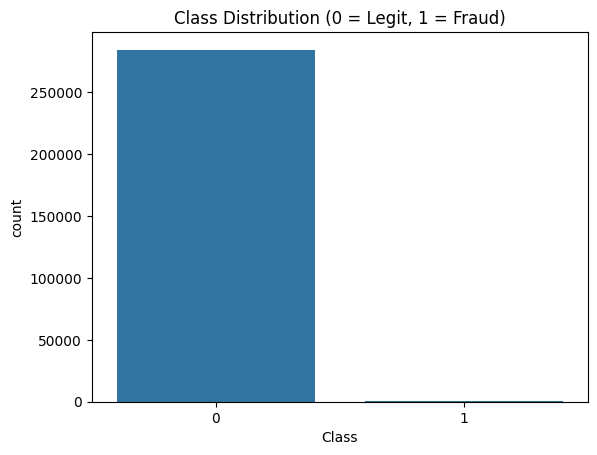

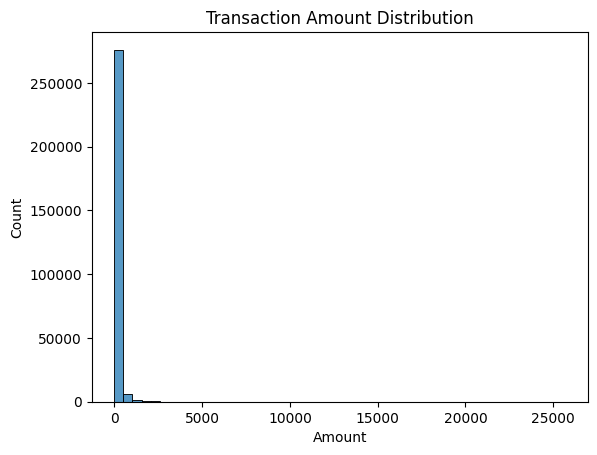

Train: (227845, 30) Test: (56962, 30)

After SMOTE: [227451 227451]

=== Training Random Forest Model ===

--- Random Forest Results ---
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8587    0.8061    0.8316        98

    accuracy                         0.9994     56962
   macro avg     0.9292    0.9029    0.9156     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9740636987068322


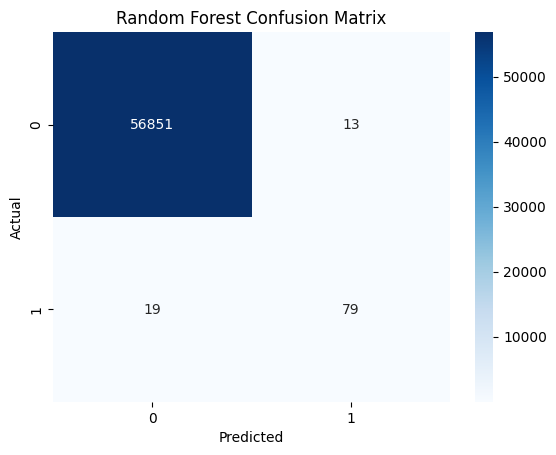

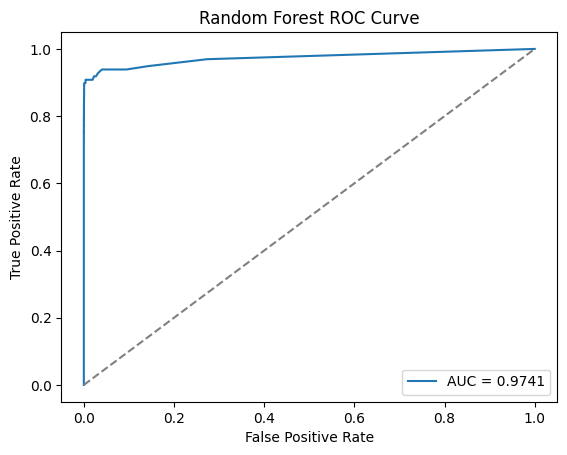

Random Forest model saved as rf_creditcard.pkl


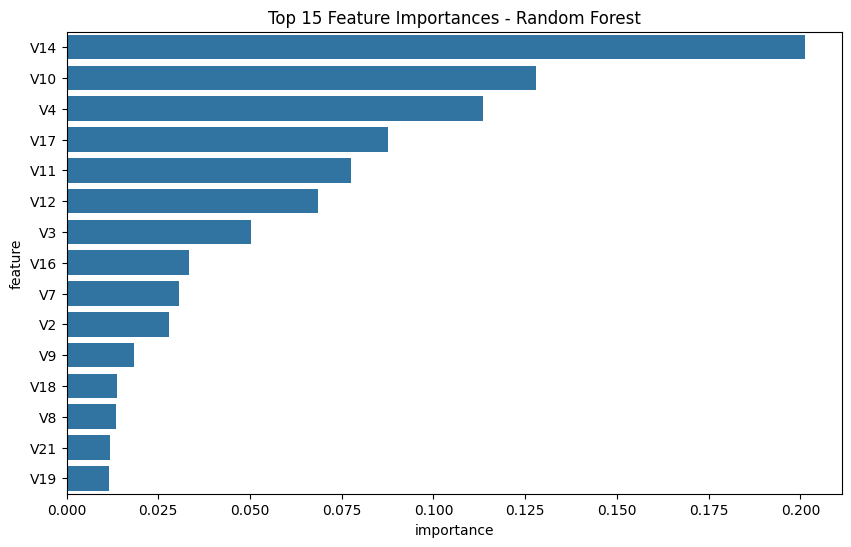


Top Feature Importances:


,feature,importance
13,V14,0.201169
9,V10,0.128089
3,V4,0.113593
16,V17,0.087572
10,V11,0.077583
11,V12,0.068519
2,V3,0.050314
15,V16,0.033370
6,V7,0.030545
1,V2,0.027961


In [1]:
# ===============================================
# FULL RANDOM FOREST MODEL PIPELINE
# ===============================================

# Cell 1: Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    auc
)

from sklearn.ensemble import RandomForestClassifier
import joblib
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Cell 2: Helper plotting functions
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def plot_roc(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.4f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

def classification_metrics(y_true, y_pred, y_scores=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_scores is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_scores))


# Cell 3: Download Dataset
import kagglehub

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", path)

df = pd.read_csv(os.path.join(path, "creditcard.csv"))
df.head()


# Cell 4: Basic EDA
print("\nClass balance:")
print(df["Class"].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.show()

sns.histplot(df['Amount'], bins=50)
plt.title("Transaction Amount Distribution")
plt.show()


# Cell 5: Feature Engineering
df["Hour"] = (df["Time"] // 3600) % 24
df["Amount_log"] = np.log1p(df["Amount"])

df_model = df.drop(["Time", "Amount"], axis=1)


# Cell 6: Train/Test Split + Scaling
X = df_model.drop("Class", axis=1)
y = df_model["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "scaler_creditcard.joblib")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


# Cell 7: SMOTE Balancing
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE:", np.bincount(y_train_sm))


# =====================================================
# Cell 8: RANDOM FOREST MODEL (Primary ML Model)
# =====================================================

print("\n=== Training Random Forest Model ===")

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_sm, y_train_sm)

# Predictions
preds_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n--- Random Forest Results ---")
classification_metrics(y_test, preds_rf, proba_rf)

plot_confusion_matrix(y_test, preds_rf, "Random Forest Confusion Matrix")
plot_roc(y_test, proba_rf, "Random Forest ROC Curve")

joblib.dump(rf, "rf_creditcard.pkl")
print("Random Forest model saved as rf_creditcard.pkl")


# =====================================================
# Cell 9: Feature Importance
# =====================================================

feat_names = X.columns
importances = rf.feature_importances_

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

print("\nTop Feature Importances:")
display(imp_df.head(15))
